### Markov simulation project: simulation of customers walking around in a supermarket
##### Part 1: Data exploration and calculation of transition matrix
##### 06th of June 2022

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings

In [2]:
# Ignore warnings
warnings.filterwarnings("ignore")

In [4]:
# Get data
df_m = pd.read_csv("data/monday.csv", sep=";", parse_dates=["timestamp"], index_col=0)
df_tu = pd.read_csv("data/tuesday.csv", sep=";", parse_dates=["timestamp"], index_col=0)
df_w = pd.read_csv("data/wednesday.csv", sep=";", parse_dates=["timestamp"], index_col=0)
df_th = pd.read_csv("data/thursday.csv", sep=";", parse_dates=["timestamp"], index_col=0)
df_f = pd.read_csv("data/friday.csv", sep=";", parse_dates=["timestamp"], index_col=0)

In [5]:
# Create DF containing all days
df = df_m.append(df_tu).append(df_w).append(df_th).append(df_f)

In [6]:
### 1. Calculate the total number of customers in each section
section_count = df.groupby("location").count()
print(f"The number of costumers in each section is: \n {section_count}")

The number of costumers in each section is: 
           customer_no
location             
checkout         7417
dairy            4679
drinks           3905
fruit            5122
spices           3754


In [7]:
### 5. Calculate the total number of customers in the supermarket over time
# Create DF for the days
day_count = pd.DataFrame()

In [8]:
# Insert weekday names for each date
day_count["customers"] = df["customer_no"].groupby(df.index.day).count()
day_count["day"] = day_count.fillna(value=0)
day_count["day"][day_count.index==2] = "monday"
day_count["day"][day_count.index==3] = "tuesday"
day_count["day"][day_count.index==4] = "wednesday"
day_count["day"][day_count.index==5] = "thursday"
day_count["day"][day_count.index==6] = "friday"

In [9]:
# Answer the question regarding the days
print(f"The number of customers on the different days are: \n {day_count}")

The number of customers on the different days are: 
            customers        day
timestamp                      
2               4884     monday
3               4714    tuesday
4               5050  wednesday
5               5104   thursday
6               5125     friday


In [10]:
# Create DF for the hours
hour_count = pd.DataFrame()
hour_count["customers"] = df["customer_no"].groupby(df.index.hour).count()

In [11]:
# Answer the question regarding the hours
print(f"The number of customers during the day are: \n {hour_count}")

The number of customers during the day are: 
            customers
timestamp           
7               1544
8               2290
9               1520
10              1431
11              1111
12              1252
13              1754
14              1650
15              1335
16              1742
17              1889
18              2215
19              2558
20              1655
21               931


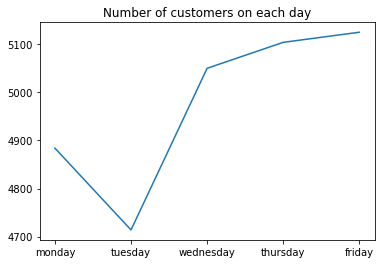

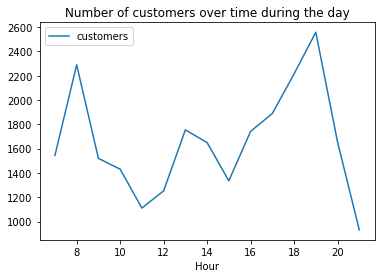

In [12]:
# Plot the data over time
days = ["monday", "tuesday", "wednesday", "thursday", "friday"]
plt.xticks(day_count.index, days)
plt.title(label="Number of customers on each day")
plt.plot(day_count.index, day_count["customers"])
hour_count.plot(title="Number of customers over time during the day", xlabel="Hour")
plt.show()
plt.close()

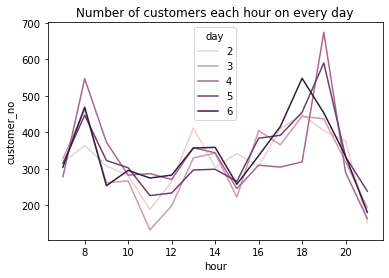

In [13]:
# Plot the data for every day over time
df_day = df.groupby([df.index.hour.rename("hour"), df.index.day.rename("day")])["customer_no"].count()
df_day = df_day.reset_index(level=1)
df_day = df_day.reset_index()
plt.title(label="Number of customers each hour on every day")
sns.lineplot(data = df_day, x = "hour", y = "customer_no", hue = "day")
plt.show()

In [14]:
### Calculate the transition times of each customer
# Add a row for every minute that a customer stays at the same location
df_filled = df.groupby(['customer_no', df.index.day]).resample('min').ffill()
df_filled = df_filled.reset_index(level=0, drop=True)

In [15]:
# Add column that includes the location of the customer at the next timestep
df_filled["after"] = df_filled.groupby(["customer_no", "timestamp"])["location"].shift(-1)
df_filled["after"] = df_filled["after"].fillna("checkout")							# Location after checkout will be NaN. This results in wrong calculations for the transition time --> fill NaN with checkout

after     checkout     dairy    drinks     fruit    spices
location                                                  
checkout  1.000000       NaN       NaN       NaN       NaN
dairy     0.103466  0.736750  0.058569  0.049848  0.051367
drinks    0.215710  0.010899  0.598499  0.087909  0.086983
fruit     0.201605  0.095924  0.054847  0.596947  0.050677
spices    0.150685  0.193214  0.163109  0.090953  0.402039


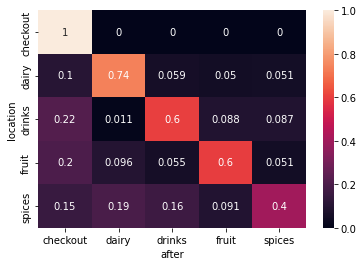

In [16]:
# Calculate the transition time for each location
trans_matrix = pd.crosstab(df_filled['location'], df_filled['after'], normalize=0)
print(df_filled.groupby("location")["after"].value_counts(normalize=True).unstack())		# Does the same as the line before
sns.heatmap(data = trans_matrix, annot=True)
plt.show()

In [17]:
# Save transition matrix to csv file
trans_matrix.to_csv("transition_matrix.csv")		# Do only one time